# Pix2Pix for object detection training set synthesis

An example of how one can synthesise a multi-class training set for object detection using a pix2pix framework. We assume we have access to a library of annotated object crops (here, MNIST digits 0 and 1). We propose a discriminator with a RoIPool (of R-CNN fame), which we find to be a workable option, and superior in our experiments to the usual PatchGAN discriminator.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import matplotlib.pyplot as plt

import torch
import torchvision

## Assemble training set

In [2]:
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST (root='/Users/jcboyd/Data/torch', train=True, download=True)
mnist_testset = datasets.MNIST(root='/Users/jcboyd/Data/torch', train=False, download=True)

x_train = (mnist_trainset.data / 127.5) - 1
x_test = (mnist_testset.data / 127.5) - 1

y_train = mnist_trainset.targets
y_test = mnist_testset.targets

idx = (y_train == 0) | (y_train == 1)

x_train = x_train[idx]
y_train = y_train[idx] # - 4

idx = (y_test == 0) | (y_test == 1)

x_test = x_test[idx]
y_test = y_test[idx] # - 4

nb_classes = torch.unique(y_train).shape[0]

In [3]:
from torch.nn import UpsamplingNearest2d

def get_canvas(x_data, y_data, num_samples=16, dim=256):

    idx = torch.randint(x_data.shape[0], size=(num_samples,))
    images = x_data[idx]
    labels = y_data[idx]

    h, w = images.shape[1:]

    canvas = -torch.ones((dim, dim))
    mask_img = -torch.ones((nb_classes, dim, dim))
    bboxes = torch.Tensor()

    for i in range(num_samples):

        y, x = (torch.randint(dim - h, size=(1,)).item(), torch.randint(dim - w, size=(1,)).item())
        canvas[y:y+h, x:x+w] = torch.max(canvas[y:y+h, x:x+w], images[i].squeeze())

        s = 4

        binary_noise = (torch.rand(h // s, w // s) > 0.5)[None, None].float()
        binary_noise = (binary_noise - 0.5) / 0.5   # normalise to [-1, 1]
        scaled_sample = UpsamplingNearest2d(scale_factor=(s, s))(binary_noise)

        mask_img[labels[i], y:y+h, x:x+w] = scaled_sample.squeeze()
        bboxes = torch.cat([bboxes, torch.tensor([[x, y, x + w, y + h]]).float()], axis=0)

    canvas = torch.clamp(canvas, -1, 1)

    return canvas[None, None], mask_img[None], bboxes


def gen_canvas(x_data, y_data, batch_size=2, num_samples=16):

    while True:

        samples = [get_canvas(x_data, y_data, num_samples) for _ in range(batch_size)]

        canvas_batch = torch.cat([sample[0] for sample in samples])
        mask_batch = torch.cat([sample[1] for sample in samples])

        bbox_batch = torch.cat([torch.cat([i * torch.ones((num_samples, 1)), sample[2]], axis=1)
                               for i, sample in enumerate(samples)], axis=0)

        yield mask_batch, canvas_batch, bbox_batch

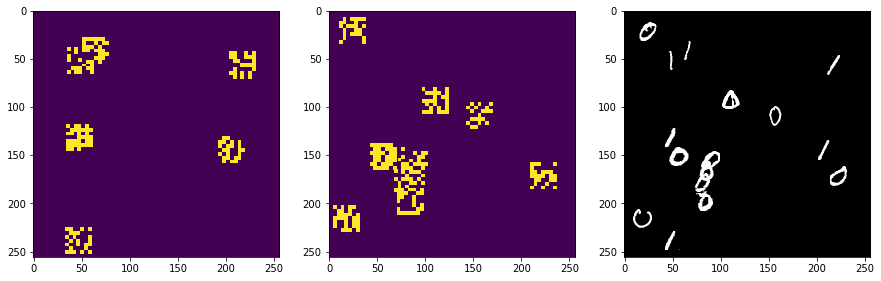

In [4]:
train_gen = gen_canvas(x_train, y_train, batch_size=2)
mask_batch, canvas_batch, bbox_batch = next(train_gen)

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

for i in range(2):
    axes[i].imshow(mask_batch[0, i - 1].squeeze())

axes[2].imshow(canvas_batch[0].squeeze(), cmap='Greys_r')

## Build model

In [5]:
# from keras.models import Model
# from keras.layers import Input
# from keras.optimizers import Adam
# from src.models import fnet, patch_gan
# from src.utils import set_trainable

# nb_classes = 2

# input_shape = mask_batch.shape[1:]     # "images"
# output_shape = canvas_batch.shape[1:]  # "labels"

# h, w, c = output_shape
# disc_patch = (h // 2 ** 4, w // 2 ** 4, c)

# optimizer = Adam(0.0002, 0.5)

# # Build discriminator
# discriminator = patch_gan(input_shape, output_shape)
# discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# # Build the generator
# generator = fnet(input_shape, 64, 'tanh')

# # Input images and their conditioning images
# images = Input(shape=input_shape)
# labels = Input(shape=output_shape)

# # By conditioning on B generate a fake version of A
# fake_labels = generator(images)

# set_trainable(discriminator, False)

# # Discriminators determines validity of translated images / condition pairs
# valid = discriminator([fake_labels, images])

# combined = Model(inputs=[images, labels], outputs=[valid, fake_labels])
# combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer)

## Train model

In [6]:
# epochs = 200
# batch_size = 2

# # Adversarial loss ground truths
# valid = np.ones((batch_size,) + disc_patch)
# fake = np.zeros((batch_size,) + disc_patch)

# train_gen = gen_canvas(x_train, y_train, batch_size)
# steps_per_epoch = 200 # x_train.shape[0] // batch_size // 4

# for epoch in range(epochs):

#     for batch_i in range(steps_per_epoch):

#         images, labels = next(train_gen)

#         # Train discriminator - condition on B and generate a translated version
#         fake_labels = generator.predict(images)

#         set_trainable(discriminator, True)

#         # Train the discriminators (original images = real / generated = Fake)
#         d_loss_real = discriminator.train_on_batch([images, labels], valid)
#         d_loss_fake = discriminator.train_on_batch([images, fake_labels], fake)
#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#         set_trainable(discriminator, False)

#         # Train the generators
#         g_loss = combined.train_on_batch([images, labels], [valid, labels])

#         # Plot the progress
#         print('[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f]' % (
#             epoch, epochs, batch_i, steps_per_epoch, d_loss[0], 100 * d_loss[1], g_loss[0]))

#     generator.save_weights('./weights/pix2pix_mnist.h5')
#     discriminator.save_weights('./weights/patch_gan_mnist.h5')

## Test model

In [7]:
# generator.load_weights('./weights/pix2pix_mnist_199.h5')
# discriminator.load_weights('./weights/patch_gan_mnist_199.h5')

# gen_test = gen_canvas(x_test, y_test, 3)
# images, labels, bboxes, roi_labels = next(gen_test)

# fake_labels = generator.predict((images + 1) / 2)

# titles = ['Original', 'Generated']
# fig, axes = plt.subplots(figsize=(10, 15), nrows=3, ncols=2)

# axes[0, 0].set_title('Original')
# axes[0, 1].set_title('Generated')

# for i in range(3):

#     axes[i, 0].imshow(labels[i].squeeze())
#     axes[i, 1].imshow(fake_labels[i].squeeze())

In [8]:
# fig, axes = plt.subplots(figsize=(10, 5), nrows=4, ncols=4)

# img = fake_labels[0, ..., 0]

# for i in range(16):

#     ax = axes[i // 4][i % 4]

#     left, top, right, bottom = list(map(int, bboxes[i, 1:]))
#     ax.imshow(img[top:bottom, left:right])#[220:250, 170:200])
#     ax.axis('off')

There is a significant degree of mode collapse in the generated objects.

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [10]:
from src.models import FNet, PatchGAN, RoIGAN

generator = FNet(nb_classes).to(device)
discriminator = PatchGAN(nb_classes,).to(device)
roi_gan = RoIGAN(nb_classes,).to(device)

total_params = 0

for params in roi_gan.parameters():
    total_params += torch.prod(torch.tensor(params.size())).item()

print(total_params)

18385


In [11]:
# from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

from src.training import train_on_batch_discriminator
from src.training import train_on_batch_roi_gan
from src.training import train_on_batch_combined


def set_trainable(model, trainable):
    for param in model.parameters():
        param.requires_grad = trainable

batch_size = 2

train_gen = gen_canvas(x_train, y_train, batch_size)
mask_batch, canvas_batch, bbox_batch = next(train_gen)

c, h, w = mask_batch.shape[1:]

disc_patch = (1, h // 2 ** 2, w // 2 ** 2)

optimiser_discriminator = Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimiser_roi = Adam(roi_gan.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimiser_combined = Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

epochs = 200
steps_per_epoch = 20

# def train_on_batch_discriminator(discriminator, imgs, optimiser):

#     images, labels, fake_labels = imgs

#     input_images = torch.cat([images, images], axis=0)
#     input_labels = torch.cat([labels, fake_labels], axis=0)

#     valid = torch.ones((batch_size,) + disc_patch)
#     fake = torch.zeros((batch_size,) + disc_patch)

#     targets = torch.cat([valid, fake], axis=0).to(device)

#     outputs = discriminator(input_images, input_labels)

#     # clear previous gradients
#     optimiser.zero_grad()

#     # forward pass
#     d_loss = MSELoss()(outputs, targets)

#     # calculate gradients
#     d_loss.backward()

#     # descent step
#     optimiser.step()

#     return d_loss


# def train_on_batch_roi_gan(roi_gan, data, optimiser):

#     images, labels, fake_labels, bboxes = data

#     num_roi = bboxes.shape[0]

#     input_images = torch.cat([images, images], axis=0)
#     input_labels = torch.cat([labels, fake_labels], axis=0)
#     input_bboxes = torch.cat([bboxes, bboxes], axis=0)

#     input_bboxes[num_roi:, 0] += batch_size  # increment image id
#     input_bboxes[:, 1:] = input_bboxes[:, 1:] / 2  # correct for pooling

#     valid = torch.ones((num_roi, 1))
#     fake = torch.zeros((num_roi, 1))

#     targets = torch.cat([valid, fake], axis=0).to(device)

#     # clear previous gradients
#     optimiser.zero_grad()

#     # forward pass
#     validity = roi_gan(input_images, input_labels, input_bboxes)

#     # calculate loss
#     d_loss = MSELoss()(validity, targets)

#     # backpropagate
#     d_loss.backward()

#     # descent step
#     optimiser.step()

#     return d_loss


# def train_on_batch_combined(models, data, optimiser):

#     # clear previous gradients
#     optimiser.zero_grad()

#     generator, discriminator, roi_gan = models
#     images, labels, bboxes = data
#     bboxes[:, 1:] = bboxes[:, 1:] / 2  # correct for pooling

#     fake_labels = generator(images)

#     # Discriminators determines validity of translated images
#     num_roi = bboxes.shape[0]
#     valid_roi = torch.ones((num_roi, 1)).to(device)
#     validity_roi = roi_gan(images, fake_labels, bboxes)

#     # Discriminators determines validity of translated images
#     valid_patch = torch.ones((batch_size,) + disc_patch).to(device)
#     validity_patch = discriminator(images, fake_labels)

#     # Best results with (0.2, 1, 5)

#     g_loss = 0.2 * MSELoss()(validity_patch, valid_patch) + \
#              1 * MSELoss()(validity_roi, valid_roi) + \
#              5 * L1Loss()(labels, fake_labels)

#     # calculate gradients
#     g_loss.backward()

#     # descent step
#     optimiser.step()

#     return g_loss


loss_record = torch.Tensor()

for epoch in range(epochs):

    for batch_i in range(steps_per_epoch):

        data = next(train_gen)
        images, labels, bboxes = data[0].to(device), data[1].to(device), data[2].to(device)

        # Generate fake images
        fake_labels = generator(images).detach()

        # Train discriminator
        set_trainable(discriminator, True)

        d_loss = torch.sqrt(train_on_batch_discriminator(discriminator,
                            [images, labels, fake_labels],
                            optimiser_discriminator, device)).item()

        set_trainable(discriminator, False)

        # Train roi discriminator
        set_trainable(roi_gan, True)

        roi_loss = torch.sqrt(train_on_batch_roi_gan(roi_gan,
                              [images, labels, fake_labels, bboxes],
                              optimiser_roi, device)).item()

        set_trainable(roi_gan, False)

        # Train combined pix2pix
        g_loss = train_on_batch_combined([generator, discriminator, roi_gan],
                                         [images, labels, bboxes],
                                         optimiser_combined, lambdas=(0.2, 1, 5), device).item()

        loss_record = torch.cat([loss_record, torch.Tensor([[d_loss, roi_loss, g_loss]])])

        # Print losses
        if batch_i % 100 == 0:
            print('[Epoch %d/%d] [Batch %03d/%d] [D loss: %f] [R loss: %f] [G loss: %05f]' % (
                epoch, epochs, batch_i, steps_per_epoch, d_loss, roi_loss, g_loss))

    # save model weights
    torch.save(generator.state_dict(), './pix2pix_generator_%d.torch' % epoch)
    torch.save(discriminator.state_dict(), './pix2pix_discriminator_%d.torch' % epoch)
    torch.save(roi_gan.state_dict(), './pix2pix_discriminator_%d.torch' % epoch)

NameError: name 'device' is not defined

In [ ]:
epoch = 199 
generator = FNet().to(device)
generator.load_state_dict(torch.load('./weights//pix2pix_generator_%d.torch' % epoch,
                                     map_location=torch.device('cpu')))
generator = generator.eval()

In [ ]:
# visualise progress
gen_test = gen_canvas(x_test, y_test, batch_size=3)
data = next(gen_test)
images, labels, bboxes = data[0].to(device), data[1].to(device), data[2].to(device)

fake_labels = generator(images)

titles = ['Original', 'Generated']
fig, axes = plt.subplots(figsize=(10, 15), nrows=3, ncols=2)

axes[0, 0].set_title('Original')
axes[0, 1].set_title('Generated')

for i in range(3):

    axes[i, 0].imshow(labels.detach().cpu().numpy()[i].squeeze())
    axes[i, 1].imshow(fake_labels.detach().cpu().numpy()[i].squeeze())

# fig.savefig('./outputs/torch_%04d.png' % epoch)
plt.show()